In [162]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [163]:
class Object:
    def __init__(self, u, v, x, y, logL, logWt):
        self.u = u  # uniform prior controlling parameter for x
        self.v = v  # uniform prior controlling parameter for y
        self.x = x  # geographical easterly position of lighthouse
        self.y = y  # geographical northerly position of lighthouse
        self.logL = logL  # logLikelihood = ln(prob(data|position))
        self.logWt = logWt  # log(Weight), adding to SUM(Wt) = Evidence Z


In [311]:
def import_txt_file_first_column_as_numbers(file_path):
    with open(file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()
        # Extract the first column and convert elements to numbers
        first_column_data = [float(line.split()[0]) for line in lines]
    return first_column_data

In [165]:
def logLhood(x, y, data):
    # x: easterly position
    # y: northerly position
    # data: a list of arrival positions of data points.
    logL = 0  # logLikelihood accumulator
    for k in range(len(data)):
        logL += math.log((y / math.pi) / ((data[k] - x) * (data[k] - x) + y * y))
    return logL

In [166]:
def Prior(obj, data):
    # Set Object attributes according to prior distributions
    obj.u = random.uniform(0, 1)  # uniform in (0,1)
    obj.v = random.uniform(0, 1)  # uniform in (0,1)
    obj.x = 4.0 * obj.u - 2.0  # map to x
    obj.y = 4.0 * obj.v  # map to y
    obj.logL = logLhood(obj.x, obj.y, data)  # Calculate log likelihood using the provided function

In [244]:
def Explore(obj, logLstar, data):
    # Evolve object within likelihood constraint
    # obj: Object being evolved
    # logLstar: Likelihood constraint L > Lstar
    step = 0.1  # Initial guess suitable step-size in (0,1)
    m = 20  # MCMC counter (pre-judged # steps)
    accept = 0  # # MCMC acceptances
    reject = 0  # # MCMC rejections
    # print("logl:", obj.logL)
    # print("logLstar:", logLstar)
    for _ in range(m):
        Try = Object(0, 0, 0, 0, 0, 0)
        # Trial object
        Try.u = obj.u + step * (2.0 * random.random() - 1.0)  # |move| < step
        Try.v = obj.v + step * (2.0 * random.random() - 1.0)  # |move| < step
        Try.u -= math.floor(Try.u)  # wraparound to stay within (0,1)
        Try.v -= math.floor(Try.v)  # wraparound to stay within (0,1)
        Try.x = 4.0 * Try.u - 2.0  # map to x
        Try.y = 4.0 * Try.v  # map to y
        Try.logL = logLhood(Try.x, Try.y, data)  # trial likelihood value
        # Accept if and only if within hard likelihood constraint
        if Try.logL > logLstar:
            obj = Try
            # print("accept_try_logl:", Try.logL)
            # print("accept_obj_logl:", obj.logL)
            accept += 1
        else:
            reject += 1
        # Refine step-size to let acceptance ratio converge around 50%
        if accept > reject:
            step *= math.exp(1.0 / accept)
        if accept < reject:
            step /= math.exp(1.0 / reject)
    # print("explorelogl:", obj.logL)
    return obj


In [169]:
def Results(samples, nest, logZ):
    """
    Calculates the mean and standard deviation of the x and y attributes of the Object instances defining the posterior distribution.

    Parameters:
    - samples: list of Object instances representing posterior samples
    - nest: number of samples in the posterior distribution
    - logZ: evidence, which is the logarithm of the total weight of all samples

    Returns:
    None (prints the mean and standard deviation of x and y attributes)
    """

    x_mean = 0.0  # Mean of x
    xx_mean = 0.0  # Second moment of x
    y_mean = 0.0  # Mean of y
    yy_mean = 0.0  # Second moment of y
    
    for i in range(nest):
        w = math.exp(samples[i].logWt - logZ)
        x_mean += w * samples[i].x
        xx_mean += w * samples[i].x * samples[i].x
        y_mean += w * samples[i].y
        yy_mean += w * samples[i].y * samples[i].y
    
    x_stddev = math.sqrt(xx_mean - x_mean * x_mean)  # Standard deviation of x
    y_stddev = math.sqrt(yy_mean - y_mean * y_mean)  # Standard deviation of y
    
    # Print the mean and standard deviation of x and y
    print("mean(x) = {}, stddev(x) = {}".format(x_mean, x_stddev))
    print("mean(y) = {}, stddev(y) = {}".format(y_mean, y_stddev))


In [170]:
def PLUS(x, y):
    if x > y:
        return x + math.log(1 + math.exp(y - x))
    else:
        return y + math.log(1 + math.exp(x - y))

In [171]:
file_path = 'lighthouse_flash_data.txt'  # Replace with the path to your text file
data = import_txt_file_first_column_as_numbers(file_path)
print(data)

[5.450773594606204, 2.8830702582459624, 0.3887351549095234, -1.1086001431531707, 1.1093576215941827, -2.628564873336912, -1.7803127570795583, 70.52898470847045, -0.18206971212870038, -0.8658217893309939, 2.375160397172225, 0.48651618047968626, -2.211555411663329, 0.9728888035186474, -4.717332724143396, -1.2713725899366266, -18.8736973698282, -1.2933359427740854, -0.6610409162732975, 13.56432676140029]


In [172]:
# Calculate the average of the data list
average = sum(data) / len(data)

# Print the average
print("Average:", average)


Average: 3.108305462537445


In [296]:
n = 100  # the number of Objects(live points)
MAX = 100000  # the number of itration
Obj = [Object(0.0, 0.0, 0.0, 0.0, 0.0, 0.0) for _ in range(n)]  # Collection of n objects
Samples = [Object(0.0, 0.0, 0.0, 0.0, 0.0, 0.0) for _ in range(MAX)]  # Objects stored for posterior results
logwidth = 0.0  # Width in prior mass
logLstar = 0.0  # Likelihood constraint
H = 0.0  # Information, initially 0
logZ = -1e300  # ln(Evidence Z), initially 0
# logZ = float('-inf')  # ln(Evidence Z), initially 0
logZnew = 0.0  # Updated logZ
i = 0  # Object counter
copy = 0  # Duplicated object
worst = 0  # Worst object
nest = 0  # Nested sampling iteration count

In [297]:
# Set prior objects
for i in range(n):
    Prior(Obj[i], data)

In [298]:
# Outermost interval of prior mass
logwidth = math.log(1.0 - math.exp(-1.0 / n))

In [299]:
# Nested Sampling Loop
for nest in range(MAX):
    # Worst object in collection, with Weight = width * Likelihood
    worst = 0
    for i in range(1, n):
        if Obj[i].logL < Obj[worst].logL:
            worst = i
    # print(worst)
    Obj[worst].logWt = logwidth + Obj[worst].logL
    
    # Update Evidence Z and Information H
    logZnew = PLUS(logZ, Obj[worst].logWt)
    H = math.exp(Obj[worst].logWt - logZnew) * Obj[worst].logL + math.exp(logZ - logZnew) * (H + logZ) - logZnew
    logZ = logZnew

    
    # Posterior Samples (optional)
    Samples[nest] = Obj[worst]  # Uncomment if you want to store posterior samples
    
    # Kill worst object in favour of copy of different survivor
    copy = int(n * random.random()) % n  # force 0 <= copy < n
    while copy == worst and n > 1:  # don’t kill if n is only 1
        copy = int(n * random.random()) % n
    logLstar = Obj[worst].logL  # new likelihood constraint
    Obj[worst] = Obj[copy]  # overwrite worst object
    
    # Evolve copied object within constraint
    Obj[worst] = Explore(Obj[worst], logLstar, data)
    # Shrink interval
    logwidth -= 1.0 / n

# NESTED SAMPLING LOOP (might be ok to terminate early)


In [300]:
# Exit with evidence Z, information H, and optional posterior Samples
# Print the number of iterations
print("# iterates =", nest+1)

# Print evidence Z and information H
print("Evidence: ln(Z) =", logZ, "+-", math.sqrt(H/n))
# print("Information: H =", H, "nats =", H/math.log(2), "bits")

# calculate and print posterior results

Results(Samples, nest, logZ)  # optional


# iterates = 100000
Evidence: ln(Z) = -64.10189502397033 +- 0.10313342270612808
mean(x) = -0.3908015937772031, stddev(x) = 0.5939066921238584
mean(y) = 1.9636912876700159, stddev(y) = 0.6176045289251807


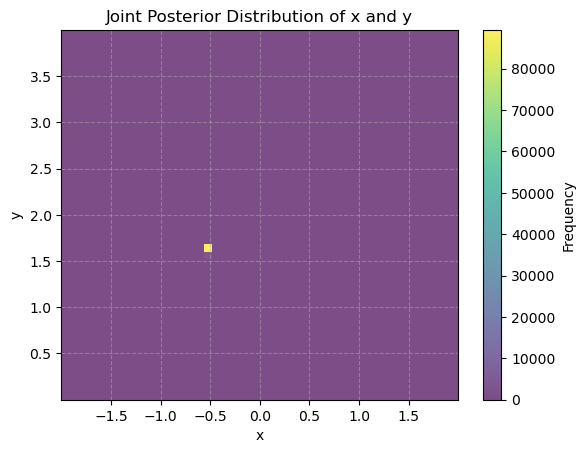

In [283]:
# # Extract x and y values from posterior samples
# x_values = [sample.x for sample in Samples[:nest]]
# y_values = [sample.y for sample in Samples[:nest]]

# # Create 2D histogram with improved visualization
# plt.hist2d(x_values, y_values, bins=50, cmap='viridis', alpha=0.7)
# plt.colorbar(label='Frequency')

# # Add gridlines
# plt.grid(True, linestyle='--', alpha=0.5)

# # Add labels and title
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Joint Posterior Distribution of x and y')

# # Show plot
# plt.show()


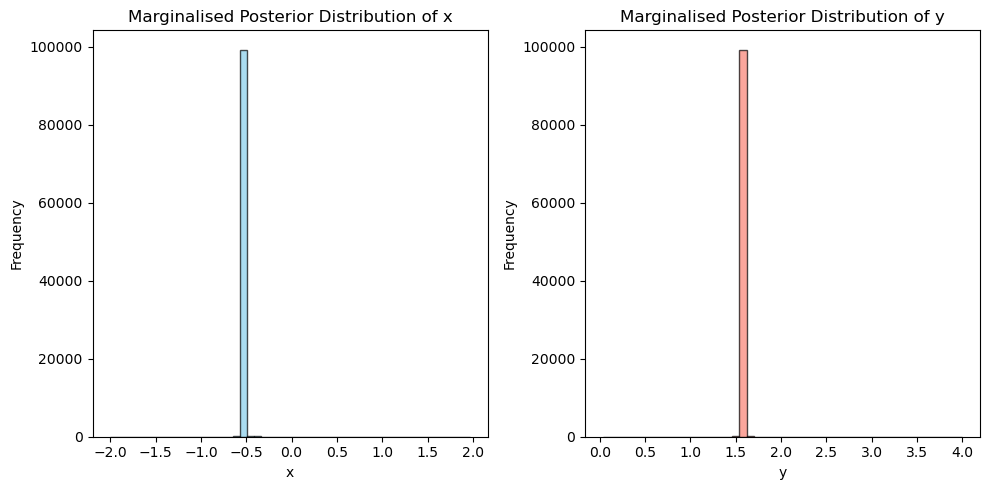

In [305]:
# x_values = [sample.x for sample in Samples[:nest]]
# y_values = [sample.y for sample in Samples[:nest]]

# # Create 1D histograms for x and y
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.hist(x_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
# plt.xlabel('x')
# plt.ylabel('Frequency')
# plt.title('Marginalised Posterior Distribution of x')

# plt.subplot(1, 2, 2)
# plt.hist(y_values, bins=50, color='salmon', edgecolor='black', alpha=0.7)
# plt.xlabel('y')
# plt.ylabel('Frequency')
# plt.title('Marginalised Posterior Distribution of y')

# plt.tight_layout()
# plt.show()


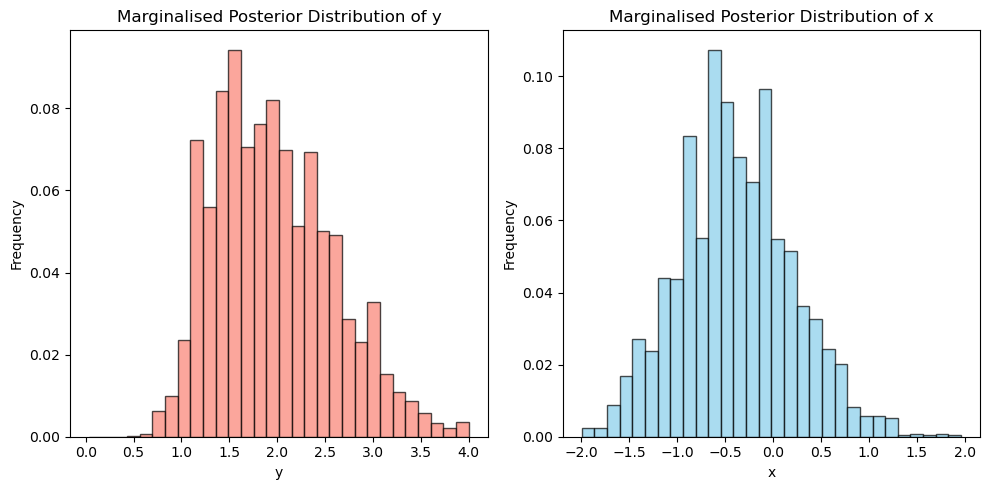

In [304]:
import matplotlib.pyplot as plt

def plot_marginal_posterior(samples, nest, logZ):
    # Create a new figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the marginal posterior distribution of y
    axs[0].hist([sample.y for sample in samples[:nest]], bins=30, weights=[math.exp(sample.logWt - logZ) for sample in samples[:nest]], color='salmon', edgecolor='black', alpha=0.7)
    axs[0].set_xlabel('y')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Marginalised Posterior Distribution of y')

    # Plot the marginal posterior distribution of x
    axs[1].hist([sample.x for sample in samples[:nest]], bins=30, weights=[math.exp(sample.logWt - logZ) for sample in samples[:nest]], color='skyblue', edgecolor='black', alpha=0.7)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Marginalised Posterior Distribution of x')

    # Adjust subplot spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
plot_marginal_posterior(Samples, nest, logZ)


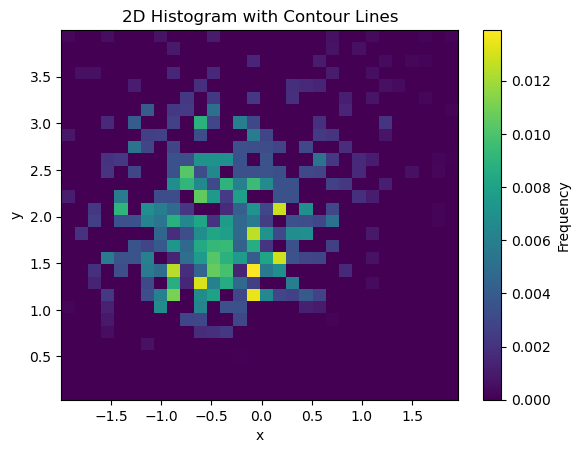

In [310]:
def plot_2d_histogram(samples, nest, logZ):
    # Extract x and y values from samples
    x_values = [sample.x for sample in samples[:nest]]
    y_values = [sample.y for sample in samples[:nest]]
    
    # Create a 2D histogram with contour lines
    plt.hist2d(x_values, y_values, bins=30, weights=[math.exp(sample.logWt - logZ) for sample in samples[:nest]], cmap='viridis')
    plt.colorbar(label='Frequency', aspect=20)

    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Histogram with Contour Lines')

    # Show the plot
    plt.show()

# Example usage:
plot_2d_histogram(Samples, nest, logZ)
